# CZ4041 - Course Project - Taxi Fare

# Exploratory Data Analysis

### Checkpoint 1 = Cell 44

## Importing the Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sb
import datetime as dt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from math import *
import json

## Loading the Datasets

In [2]:
df_train = pd.read_csv("train.csv")
#df_test = pd.read_csv("test.csv")

In [3]:
#displaying the first 5 rows of train 
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
#displaying the first 5 rows of test
#df_test.head()

In [5]:
#shape of df_train
print("df_train shape:",df_train.shape)
#shape of df_test
#print("df_test shape:", df_test.shape)

df_train shape: (55423856, 8)


The test has one column lesser than train set as the test set does not contain the labels.

In [6]:
columns = df_train.columns
print("Columns:", list(columns))
print("Length of Columns:", len(columns))

Columns: ['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
Length of Columns: 8


## Data Cleaning

### Deleting the rows where pickup/dropoff_datetime, pickup/dropoff_longitude, pickup/dropoff_latitude are 0

In [7]:
df_train_copy = df_train.copy()
train_wo_zeros = df_train_copy[(df_train_copy.pickup_datetime != 0) & (df_train_copy.pickup_latitude != 0) & (df_train_copy.dropoff_latitude != 0) & (df_train_copy.pickup_longitude != 0) & (df_train_copy.dropoff_longitude != 0)]
train_wo_zeros

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
55423851,2014-03-15 03:28:00.00000070,14.0,2014-03-15 03:28:00 UTC,-74.005272,40.740027,-73.963280,40.762555,1
55423852,2009-03-24 20:46:20.0000002,4.2,2009-03-24 20:46:20 UTC,-73.957784,40.765530,-73.951640,40.773959,1
55423853,2011-04-02 22:04:24.0000004,14.1,2011-04-02 22:04:24 UTC,-73.970505,40.752325,-73.960537,40.797342,1
55423854,2011-10-26 05:57:51.0000002,28.9,2011-10-26 05:57:51 UTC,-73.980901,40.764629,-73.870605,40.773963,1


In [8]:
print("Shape of df initially:", df_train.shape)
print("Shape after removing rows with 4 0s:", train_wo_zeros.shape)
print("Number of rows with 4 0s:", df_train.shape[0] - train_wo_zeros.shape[0])

Shape of df initially: (55423856, 8)
Shape after removing rows with 4 0s: (54319366, 8)
Number of rows with 4 0s: 1104490


In [9]:
#Resetting the index, inplace to make sure the indexes are all correct
train_wo_zeros.reset_index(inplace=True)
train_wo_zeros.tail()

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
54319361,55423851,2014-03-15 03:28:00.00000070,14.0,2014-03-15 03:28:00 UTC,-74.005272,40.740027,-73.963280,40.762555,1
54319362,55423852,2009-03-24 20:46:20.0000002,4.2,2009-03-24 20:46:20 UTC,-73.957784,40.765530,-73.951640,40.773959,1
54319363,55423853,2011-04-02 22:04:24.0000004,14.1,2011-04-02 22:04:24 UTC,-73.970505,40.752325,-73.960537,40.797342,1
54319364,55423854,2011-10-26 05:57:51.0000002,28.9,2011-10-26 05:57:51 UTC,-73.980901,40.764629,-73.870605,40.773963,1
54319365,55423855,2014-12-12 11:33:00.00000015,7.5,2014-12-12 11:33:00 UTC,-73.969722,40.797668,-73.970885,40.783313,1


### Dealing with Null Values

In [10]:
#checking which columns have NaN values
train_wo_zeros.isnull().any()

index                False
key                  False
fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude     True
dropoff_latitude      True
passenger_count      False
dtype: bool

Therefore, dropoff_longitude and dropoff_latitude have NaN in them.

In [11]:
nan_rows_lat = train_wo_zeros[train_wo_zeros['dropoff_latitude'].isnull()]
nan_rows_long = train_wo_zeros[train_wo_zeros['dropoff_longitude'].isnull()]

print("nan_rows_lat:", nan_rows_lat)
print("# of rows:", nan_rows_lat.shape[0])

print("nan_rows_long:", nan_rows_long)
print("# of rows:", nan_rows_long.shape[0])

nan_rows_lat:              index                           key  fare_amount  \
117801      120227  2012-12-11 12:57:00.00000013        12.50   
240885      245696   2013-03-21 18:07:07.0000001        86.50   
333842      340533  2012-12-11 12:50:52.00000010        27.50   
419621      428108   2011-09-08 09:12:52.0000001        11.80   
514475      524834   2011-09-25 23:01:12.0000005        14.76   
...            ...                           ...          ...   
53492512  54580245   2012-11-16 17:44:07.0000002        44.00   
53589436  54679078   2011-11-07 08:14:05.0000004        13.42   
53803790  54897759   2012-12-11 12:51:34.0000002         8.50   
53869393  54964682   2011-10-04 02:39:52.0000001        12.36   
54152201  55253379   2013-10-10 08:20:25.0000005         6.00   

                  pickup_datetime  pickup_longitude  pickup_latitude  \
117801    2012-12-11 12:57:00 UTC        -73.992760        40.743098   
240885    2013-03-21 18:07:07 UTC        -73.991572        40

In [12]:
nan_rows_lat_idx = list(nan_rows_lat.index)
nan_rows_long_idx = list(nan_rows_long.index)

In [13]:
#viewing one particular row to analyse it further
train_wo_zeros.iloc[nan_rows_lat_idx[0]]

index                                      120227
key                  2012-12-11 12:57:00.00000013
fare_amount                                  12.5
pickup_datetime           2012-12-11 12:57:00 UTC
pickup_longitude                        -73.99276
pickup_latitude                         40.743098
dropoff_longitude                             NaN
dropoff_latitude                              NaN
passenger_count                                 0
Name: 117801, dtype: object

In [14]:
#checking if both nan_rows_lat_idx and nan_rows_long_idx are the same
if nan_rows_lat_idx == nan_rows_long_idx:
    print("Both the Lists are identical! Therefore, just using one list will do!")
else:
    print("Both lists are not identical! Hence, we need to account for repeated row indices!")

Both the Lists are identical! Therefore, just using one list will do!


The lists nan_rows_lat_idx and nan_rows_long_idx contain the indices of the rows that contain both dropoff_latitude and dropoff_longitude as NaN. There is no case where either one of them is a NaN and the other one if a valid value, this is because, form the test above, both the lists are identical, whoch means the row indices are exact same, hence, there exists only the case where either both of the column's vlaues are NaN or None of it. Hence, we will just be using the nan_rows_lat_idx to remove the rows that contain NaN.

In [15]:
#creating a copy of the existing df
train_wo_nan = train_wo_zeros.copy()

In [16]:
#dropping the rows with NaN
train_wo_nan.drop(axis=0, index=nan_rows_lat_idx,inplace=True)

#resetting the index
train_wo_nan.reset_index(inplace=True)

In [17]:
#Math to check 
NUM_NAN_ROWS = len(nan_rows_lat_idx)

print("Number of rows before dropping NaN rows:", train_wo_zeros.shape[0])

if train_wo_zeros.shape[0] - train_wo_nan.shape[0] == NUM_NAN_ROWS:
    print("Successfully dropped ", NUM_NAN_ROWS, "rows!")
    print("Number of rows in train_wo_nan:", train_wo_nan.shape[0])
else:
    print("Error! Dropped Wrong Number of Rows!")

Number of rows before dropping NaN rows: 54319366
Successfully dropped  335 rows!
Number of rows in train_wo_nan: 54319031


In [18]:
#removing columns that were unintentionally added at the backend 
train_wo_nan.drop(['level_0','index'], axis = 1, inplace=True)

In [19]:
train_wo_nan

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
54319026,2014-03-15 03:28:00.00000070,14.0,2014-03-15 03:28:00 UTC,-74.005272,40.740027,-73.963280,40.762555,1
54319027,2009-03-24 20:46:20.0000002,4.2,2009-03-24 20:46:20 UTC,-73.957784,40.765530,-73.951640,40.773959,1
54319028,2011-04-02 22:04:24.0000004,14.1,2011-04-02 22:04:24 UTC,-73.970505,40.752325,-73.960537,40.797342,1
54319029,2011-10-26 05:57:51.0000002,28.9,2011-10-26 05:57:51 UTC,-73.980901,40.764629,-73.870605,40.773963,1


In [20]:
#cross-checking if there are any NaN values at all
train_wo_nan.isnull().any()

key                  False
fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude    False
dropoff_latitude     False
passenger_count      False
dtype: bool

### Dealing with passenger_count == 0

In [21]:
#checking if there are any rows where the passenger_count == 0
(train_wo_nan['passenger_count'] == 0).any()

True

Since the output is True, it means that there are rows where the passenger_count == 0. Let's look deeper into this!

In [22]:
count = (train_wo_nan['passenger_count'] == 0).sum()
print("Number of 0s in passenger_count:", count)

Number of 0s in passenger_count: 190853


In [23]:
zero_values = train_wo_nan[train_wo_nan['passenger_count'] == 0]
zero_values

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
307,2015-06-02 23:16:15.00000012,34.0,2015-06-02 23:16:15 UTC,-73.974899,40.751095,-73.908546,40.881878,0
552,2012-01-28 21:33:18.0000002,4.9,2012-01-28 21:33:18 UTC,-73.955322,40.782840,-73.955797,40.773673,0
662,2012-02-27 07:24:20.0000003,6.5,2012-02-27 07:24:20 UTC,-73.983397,40.738183,-73.971395,40.758023,0
1135,2011-05-25 23:58:48.0000001,13.3,2011-05-25 23:58:48 UTC,-73.998360,40.740348,-73.946455,40.777348,0
1894,2011-10-23 11:09:28.0000001,10.1,2011-10-23 11:09:28 UTC,-73.971400,40.795000,-73.967900,40.768600,0
...,...,...,...,...,...,...,...,...
54317488,2011-07-31 15:25:05.0000004,17.7,2011-07-31 15:25:05 UTC,-73.975100,40.681000,-73.980300,40.742400,0
54318106,2011-10-19 18:46:09.0000001,11.7,2011-10-19 18:46:09 UTC,-73.985200,40.755900,-73.972000,40.764700,0
54318152,2012-02-08 23:52:37.0000001,6.9,2012-02-08 23:52:37 UTC,-74.004172,40.751831,-73.994318,40.738853,0
54318172,2011-10-21 10:21:32.0000003,6.5,2011-10-21 10:21:32 UTC,-73.982300,40.768100,-73.968200,40.760400,0


In [24]:
#Obtaining the indices of rows where passenger_count == 0 and converting it into a list
zero_values_idx = list(zero_values.index)
#zero_values_idx

In [25]:
pass_count_dropped = train_wo_nan.copy()

In [26]:
#dropping the rows
pass_count_dropped.drop(axis=0, index=zero_values_idx,inplace=True)

#resetting the index
pass_count_dropped.reset_index(inplace=True)

pass_count_dropped

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...,...
54128173,54319026,2014-03-15 03:28:00.00000070,14.0,2014-03-15 03:28:00 UTC,-74.005272,40.740027,-73.963280,40.762555,1
54128174,54319027,2009-03-24 20:46:20.0000002,4.2,2009-03-24 20:46:20 UTC,-73.957784,40.765530,-73.951640,40.773959,1
54128175,54319028,2011-04-02 22:04:24.0000004,14.1,2011-04-02 22:04:24 UTC,-73.970505,40.752325,-73.960537,40.797342,1
54128176,54319029,2011-10-26 05:57:51.0000002,28.9,2011-10-26 05:57:51 UTC,-73.980901,40.764629,-73.870605,40.773963,1


In [27]:
NUM_PASS_COUNT_0 = len(zero_values_idx)
print("Number of rows before dropping passenger_count == 0 rows:", train_wo_nan.shape[0])

if (train_wo_nan.shape[0] - pass_count_dropped.shape[0] == NUM_PASS_COUNT_0):
    print("Successfully dropped ", NUM_PASS_COUNT_0, "rows!")
    print("Number of rows in pass_count_dropped:", pass_count_dropped.shape[0])
else:
    print("Error! Dropped Wrong Number of Rows!")

Number of rows before dropping passenger_count == 0 rows: 54319031
Successfully dropped  190853 rows!
Number of rows in pass_count_dropped: 54128178


In [28]:
#Dropping unnecessary columns from the df 
pass_count_dropped.drop(['index'], axis = 1, inplace=True)
pass_count_dropped

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
54128173,2014-03-15 03:28:00.00000070,14.0,2014-03-15 03:28:00 UTC,-74.005272,40.740027,-73.963280,40.762555,1
54128174,2009-03-24 20:46:20.0000002,4.2,2009-03-24 20:46:20 UTC,-73.957784,40.765530,-73.951640,40.773959,1
54128175,2011-04-02 22:04:24.0000004,14.1,2011-04-02 22:04:24 UTC,-73.970505,40.752325,-73.960537,40.797342,1
54128176,2011-10-26 05:57:51.0000002,28.9,2011-10-26 05:57:51 UTC,-73.980901,40.764629,-73.870605,40.773963,1


In [29]:
#checking if passenger_count == 0 still exists
(pass_count_dropped['passenger_count'] == 0).any()

False

Since, the output is False, it means that there are no more rows where passenger_count == 0.

### Visualising Passenger Count

We would like to visualise the distribution of passenger_count to check if there are any logical discrepancies. According to this source, by law an NYC Taxi is allowed to carry only 4 passengers and 5 passengers, if it is a 5 seater car. Passenger Count of greater than 5 is only allowed if children aged 7 or above are seated on the laps of the adult passenger. 

Hence, if the maximum number of adults seated is 5, then the maximum number of passengers in a taxi will be 5 + 5 = 10, assuming that each adult seated has a child he/she is holding onto.

Hence, to ensure that this logic is not violated, we aim to visualise the distribution of the passenger_count variable and remove rows that contain values gretaer than 10.

Link: https://www.google.com/urlsa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiew7PRucj2AhUjSWwGHZjiD_QQFnoECAsQAw&url=https%3A%2F%2Fwww1.nyc.gov%2Fsite%2Ftlc%2Fpassengers%2Fpassenger-frequently-askedquestions.page&usg=AOvVaw0lJJHgeBfD9Fi_4wir5Bgl

In [30]:
#extracting only the passeneger_count variable as a dataframe
passenger_count = pass_count_dropped[['passenger_count']]

print(type(passenger_count))

<class 'pandas.core.frame.DataFrame'>


In [31]:
#analysing the inputs in the passenger_count column
passenger_count.value_counts()

passenger_count
1                  37560913
2                   8022344
5                   3848449
3                   2386087
4                   1156834
6                   1153482
208                      25
9                        21
7                        13
8                         7
129                       2
34                        1
dtype: int64

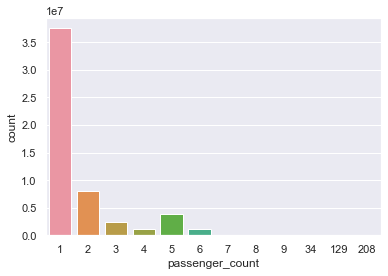

In [32]:
#Plotting a Countplot
sb.set_theme(style="darkgrid")
ax = sb.countplot(x="passenger_count",data=passenger_count)

As we can see, majority of the records have only 1 passenger. However, there seem to be records that have 34, 129 and 208 passengers in the taxi. This is not logically possible, hence, this rows will be removed.

In [33]:
final_pass_count = pass_count_dropped.copy()

In [34]:
illogical_rows= final_pass_count[(final_pass_count['passenger_count'] == 34) | (final_pass_count['passenger_count'] == 129) | (final_pass_count['passenger_count'] == 208)]
illogical_rows

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
3034937,2009-05-12 14:50:00.000000175,2.7,2009-05-12 14:50:00 UTC,-73.937818,40.758260,-73.937827,40.758250,208
3246166,2011-08-27 01:24:00.000000168,8.5,2011-08-27 01:24:00 UTC,-73.987858,40.760340,-74.000682,40.752413,129
4328865,2009-05-11 13:56:00.00000088,11.1,2009-05-11 13:56:00 UTC,-73.937733,40.758267,-73.937737,40.758273,208
6837485,2009-02-26 08:29:00.000000201,2.7,2009-02-26 08:29:00 UTC,-73.937872,40.758333,-73.937835,40.758368,208
11006578,2010-11-02 11:54:00.00000099,3.3,2010-11-02 11:54:00 UTC,-115.232922,36.217767,-115.232918,36.217718,208
13641604,2010-03-23 13:22:00.00000022,7.1,2010-03-23 13:22:00 UTC,-73.936945,40.758053,-73.936945,40.758053,208
17540626,2010-09-21 17:19:00.000000179,13.3,2010-09-21 17:19:00 UTC,-73.959862,40.767532,-73.937847,54.787017,34
20040214,2010-12-29 12:33:00.00000081,3.3,2010-12-29 12:33:00 UTC,-73.937727,40.758580,-73.937715,40.758605,208
21206294,2009-07-06 22:53:00.00000013,2.7,2009-07-06 22:53:00 UTC,-73.937767,40.758258,-73.937782,40.758330,208
28359772,2009-05-04 23:08:00.00000058,7.1,2009-05-04 23:08:00 UTC,-73.937755,40.758378,-73.937830,40.758265,208


In [35]:
print("Number of illogical rows:", illogical_rows.shape[0])

Number of illogical rows: 28


In [36]:
illogical_rows_idx = list(illogical_rows.index)
NUM_ILLOGICAL_ROWS = len(illogical_rows_idx)
NUM_ILLOGICAL_ROWS

28

In [37]:
#dropping the rows
final_pass_count.drop(axis=0, index=illogical_rows_idx,inplace=True)

#resetting the index
final_pass_count.reset_index(inplace=True)

final_pass_count

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...,...
54128145,54128173,2014-03-15 03:28:00.00000070,14.0,2014-03-15 03:28:00 UTC,-74.005272,40.740027,-73.963280,40.762555,1
54128146,54128174,2009-03-24 20:46:20.0000002,4.2,2009-03-24 20:46:20 UTC,-73.957784,40.765530,-73.951640,40.773959,1
54128147,54128175,2011-04-02 22:04:24.0000004,14.1,2011-04-02 22:04:24 UTC,-73.970505,40.752325,-73.960537,40.797342,1
54128148,54128176,2011-10-26 05:57:51.0000002,28.9,2011-10-26 05:57:51 UTC,-73.980901,40.764629,-73.870605,40.773963,1


In [38]:
print("Number of rows before dropping passenger_count == 34,129,208 rows:", pass_count_dropped.shape[0])

if (pass_count_dropped.shape[0] - final_pass_count.shape[0] == NUM_ILLOGICAL_ROWS):
    print("Successfully dropped ", NUM_ILLOGICAL_ROWS, "rows!")
    print("Number of rows in final_pass_count:", final_pass_count.shape[0])
else:
    print("Error! Dropped Wrong Number of Rows!")

Number of rows before dropping passenger_count == 34,129,208 rows: 54128178
Successfully dropped  28 rows!
Number of rows in final_pass_count: 54128150


In [39]:
#Dropping unnecessary columns from the df 
final_pass_count.drop(['index'], axis = 1, inplace=True)
final_pass_count

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
54128145,2014-03-15 03:28:00.00000070,14.0,2014-03-15 03:28:00 UTC,-74.005272,40.740027,-73.963280,40.762555,1
54128146,2009-03-24 20:46:20.0000002,4.2,2009-03-24 20:46:20 UTC,-73.957784,40.765530,-73.951640,40.773959,1
54128147,2011-04-02 22:04:24.0000004,14.1,2011-04-02 22:04:24 UTC,-73.970505,40.752325,-73.960537,40.797342,1
54128148,2011-10-26 05:57:51.0000002,28.9,2011-10-26 05:57:51 UTC,-73.980901,40.764629,-73.870605,40.773963,1


In [40]:
#Visualising passenger_count again to cross-check
final_pass_count['passenger_count'].value_counts()

1    37560913
2     8022344
5     3848449
3     2386087
4     1156834
6     1153482
9          21
7          13
8           7
Name: passenger_count, dtype: int64

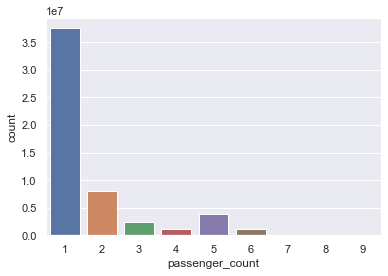

In [41]:
#Plotting a Countplot
sb.set_theme(style="darkgrid")
ax = sb.countplot(x="passenger_count",data=final_pass_count)

### Cheking if the label has any Negative Values

In [42]:
final_fare_amt = final_pass_count.copy()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [43]:
#checking if there is any negative value in fare_amt
(final_fare_amt['fare_amount'] < 0).any()

True

In [ ]:
final_fare_amt.to_csv('D:\ML Files\checkpoint-1.csv', index=False)

Therefore, there are negative values in the label, which are illogical.

# Checkpoint 1

In [ ]:
final_fare_amt = pd.read_csv('D:\ML Files\checkpoint-1.csv')

In [ ]:
negative_rows = final_fare_amt[final_fare_amt['fare_amount'] < 0]
#negative_rows

In [6]:
negative_rows_idx = list(negative_rows.index)
#negative_rows_idx

In [7]:
#looking at a specific row 
final_fare_amt.iloc[negative_rows_idx[0]]

key                  2010-03-09 23:37:10.0000005
fare_amount                                 -2.9
pickup_datetime          2010-03-09 23:37:10 UTC
pickup_longitude                       -73.78945
pickup_latitude                        40.643498
dropoff_longitude                     -73.788665
dropoff_latitude                       40.641952
passenger_count                                1
Name: 1992, dtype: object

In [8]:
#dropping the rows
final_fare_amt.drop(axis=0, index=negative_rows_idx,inplace=True)

#resetting the index
final_fare_amt.reset_index(inplace=True)

#final_fare_amt

In [9]:
# NUM_NEGATIVE_FARE = len(negative_rows_idx)
# print("Number of rows before dropping fare_amt < 0:", final_pass_count.shape[0])

# if (final_pass_count.shape[0] - final_fare_amt.shape[0] == NUM_NEGATIVE_FARE):
#     print("Successfully dropped ", NUM_NEGATIVE_FARE, "rows!")
#     print("Number of rows in final_fare_amount:", final_fare_amt.shape[0])
# else:
#     print("Error! Dropped Wrong Number of Rows!")

In [10]:
#Dropping unnecessary columns from the df 
final_fare_amt.drop(['index'], axis = 1, inplace=True)
final_fare_amt

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
54125939,2014-03-15 03:28:00.00000070,14.0,2014-03-15 03:28:00 UTC,-74.005272,40.740027,-73.963280,40.762555,1
54125940,2009-03-24 20:46:20.0000002,4.2,2009-03-24 20:46:20 UTC,-73.957784,40.765530,-73.951640,40.773959,1
54125941,2011-04-02 22:04:24.0000004,14.1,2011-04-02 22:04:24 UTC,-73.970505,40.752325,-73.960537,40.797342,1
54125942,2011-10-26 05:57:51.0000002,28.9,2011-10-26 05:57:51 UTC,-73.980901,40.764629,-73.870605,40.773963,1


In [11]:
#cross-checking if there is any negative value in fare_amt
(final_fare_amt['fare_amount'] < 0).any()

False

Things to do:
1. Need to create a binary variable called weekend - to check if its a weekend or not
2. Need to create a binary variable called holiday - to check if it is a public holiday or not
3. Need to code for the equation -> need to read up on what model can be used!

In [12]:
import datetime as dt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [13]:
datetime_list = []
for datetime_str in final_fare_amt['pickup_datetime']:
    datetime_value = dt.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S UTC')
    date = datetime_value.date() 
    time = datetime_value.time()
    day = datetime_value.weekday()
    weekend = (day>=4)
    datetime_list.append([date,time,day,weekend])
    #print(date)

In [14]:
date_series = pd.Series(v[0] for v in datetime_list)
time_series = pd.Series(v[1] for v in datetime_list)
day_series = pd.Series(v[2] for v in datetime_list)
weekend_series = pd.Series(v[3] for v in datetime_list)

In [15]:
cal = calendar()
holidays = cal.holidays(start= date_series.min(), end=date_series.max())
holidays = [x.date() for x in holidays]
print("Earliest Date in Train Datatset:",date_series.min())
print("Latest Date in Train Dataset:",date_series.max())

Earliest Date in Train Datatset: 2009-01-01
Latest Date in Train Dataset: 2015-06-30


In [16]:
holiday_list = []
for date in date_series: 
    if date in holidays:
        holiday_list.append(int(1))
    else: 
        holiday_list.append(int(0))   
holiday_series = pd.Series(v for v in holiday_list)

In [17]:
holiday = new_combined[new_combined["holiday"] == 1 ]

In [18]:
holiday.head(25)

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,date,time,day,weekend,holiday
53,53,2010-05-31 18:06:00.00000097,34.67,2010-05-31 18:06:00 UTC,-73.985427,40.758853,-73.872907,40.774497,1,2010-05-31,18:06:00,0,False,1
59,59,2012-01-02 14:54:00.00000078,4.90,2012-01-02 14:54:00 UTC,-74.003985,40.731677,-73.999765,40.723512,1,2012-01-02,14:54:00,0,False,1
177,177,2009-09-07 18:52:00.000000158,8.10,2009-09-07 18:52:00 UTC,-73.952198,40.788107,-73.980767,40.774995,1,2009-09-07,18:52:00,0,False,1
210,210,2015-05-25 15:11:09.0000006,11.00,2015-05-25 15:11:09 UTC,-73.972214,40.765572,-73.979584,40.736469,1,2015-05-25,15:11:09,0,False,1
275,275,2013-01-01 14:26:00.000000162,9.00,2013-01-01 14:26:00 UTC,-73.969465,40.797980,-73.982315,40.776767,1,2013-01-01,14:26:00,1,False,1
306,306,2011-11-24 01:58:25.0000001,20.50,2011-11-24 01:58:25 UTC,-73.965723,40.758641,-73.937824,40.855636,1,2011-11-24,01:58:25,3,False,1
338,338,2014-01-01 05:22:00.00000048,5.00,2014-01-01 05:22:00 UTC,-73.994360,40.720390,-73.985770,40.723040,2,2014-01-01,05:22:00,2,False,1
423,423,2010-11-11 21:18:00.00000079,8.90,2010-11-11 21:18:00 UTC,-73.981872,40.760252,-74.002232,40.740567,5,2010-11-11,21:18:00,3,False,1
434,434,2015-02-16 17:12:44.0000005,6.00,2015-02-16 17:12:44 UTC,-73.957619,40.766773,-73.955826,40.778767,1,2015-02-16,17:12:44,0,False,1
440,440,2010-11-25 22:54:00.00000017,11.30,2010-11-25 22:54:00 UTC,-74.005448,40.725823,-74.005942,40.725048,2,2010-11-25,22:54:00,3,False,1


In [17]:
new_combined = final_fare_amt.copy()
new_combined = new_combined.reset_index() 

False

In [18]:
new_combined['date'] = date_series
new_combined['time'] = time_series
new_combined['day'] = day_series
new_combined['weekend'] = weekend_series
new_combined['holiday'] = holiday_series

In [19]:
new_combined.head(25)

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,date,time,day,weekend,holiday
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,17:26:21,0,False,0
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,16:52:16,1,False,0
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,00:35:00,3,False,0
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,04:30:42,5,True,0
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,07:51:00,1,False,0
5,5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1,2011-01-06,09:50:45,3,False,0
6,6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1,2012-11-20,20:35:00,1,False,0
7,7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1,2012-01-04,17:22:00,2,False,0
8,8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1,2012-12-03,13:10:00,0,False,0
9,9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2,2009-09-02,01:11:00,2,False,0


In [21]:
new_combined

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,date,time,day,weekend,holiday
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,17:26:21,0,False,0
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,16:52:16,1,False,0
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,00:35:00,3,False,0
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,04:30:42,5,True,0
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,07:51:00,1,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54125939,54125939,2014-03-15 03:28:00.00000070,14.0,2014-03-15 03:28:00 UTC,-74.005272,40.740027,-73.963280,40.762555,1,2014-03-15,03:28:00,5,True,0
54125940,54125940,2009-03-24 20:46:20.0000002,4.2,2009-03-24 20:46:20 UTC,-73.957784,40.765530,-73.951640,40.773959,1,2009-03-24,20:46:20,1,False,0
54125941,54125941,2011-04-02 22:04:24.0000004,14.1,2011-04-02 22:04:24 UTC,-73.970505,40.752325,-73.960537,40.797342,1,2011-04-02,22:04:24,5,True,0
54125942,54125942,2011-10-26 05:57:51.0000002,28.9,2011-10-26 05:57:51 UTC,-73.980901,40.764629,-73.870605,40.773963,1,2011-10-26,05:57:51,2,False,0


In [22]:
new_combined.to_csv('D:\ML Files\checkpoint-2.csv', index=False)

# Checkpoint 2

In [5]:
new_combined = pd.read_csv('D:\ML Files\checkpoint-2.csv')

In [6]:
new_combined.head(25)

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,date,time,day,weekend,holiday
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,17:26:21,0,False,0
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,16:52:16,1,False,0
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,00:35:00,3,False,0
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,04:30:42,5,True,0
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,07:51:00,1,False,0
5,5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1,2011-01-06,09:50:45,3,False,0
6,6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1,2012-11-20,20:35:00,1,False,0
7,7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1,2012-01-04,17:22:00,2,False,0
8,8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1,2012-12-03,13:10:00,0,False,0
9,9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2,2009-09-02,01:11:00,2,False,0


In [7]:
new_combined.isnull().values.any()

False

### Dropping pickup date time, key and index

In [8]:
new_combined.drop(columns=['key','pickup_datetime','index'])

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,date,time,day,weekend,holiday
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,17:26:21,0,False,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,16:52:16,1,False,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,00:35:00,3,False,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,04:30:42,5,True,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,07:51:00,1,False,0
...,...,...,...,...,...,...,...,...,...,...,...
54125939,14.0,-74.005272,40.740027,-73.963280,40.762555,1,2014-03-15,03:28:00,5,True,0
54125940,4.2,-73.957784,40.765530,-73.951640,40.773959,1,2009-03-24,20:46:20,1,False,0
54125941,14.1,-73.970505,40.752325,-73.960537,40.797342,1,2011-04-02,22:04:24,5,True,0
54125942,28.9,-73.980901,40.764629,-73.870605,40.773963,1,2011-10-26,05:57:51,2,False,0


### Checking peak hour if pickup time is a peak hour

In [9]:
peak_hour_df= new_combined[['time','day']]
peak_hour_df

,time,day
0,17:26:21,0
1,16:52:16,1
2,00:35:00,3
3,04:30:42,5
4,07:51:00,1
...,...,...
54125939,03:28:00,5
54125940,20:46:20,1
54125941,22:04:24,5
54125942,05:57:51,2


In [24]:
# Initalise peak hour timings
def in_between(now, start, end):
    if start <= end:
        return start < now <= end
    else: # over midnight e.g., 23:30-04:15
        return start < now or now <= end
    
    
morning_from = dt.time(7,0,0)
morning_till = dt.time(9,0,0)

evening_from = dt.time(15,0,0)
evening_till = dt.time(19,0,0)

evening_from_fri = dt.time(14,0,0)

peak_hour_list = []
for index, row in peak_hour_df.iterrows():
    #time = row['time']
    time = dt.datetime.strptime(row['time'], '%H:%M:%S').time() 
    
    # If day is Mon - Thur ------------
    if 0 <= row['day'] <= 3:
        if in_between(time, morning_from, morning_till) or in_between(time, evening_from, evening_till):
            peak_hour_list.append(int(1))
        else:
            peak_hour_list.append(int(0))
    # If day is Friday -----------------
    
    elif row['day'] == 4: 
        if in_between(time, morning_from, morning_till) or in_between(time, evening_from_fri, evening_till):
            peak_hour_list.append(int(1))
        else:
            peak_hour_list.append(int(0))
    # If day is Sat - Sun 
    else: 
        peak_hour_list.append(int(0)) 

In [ ]:
peak_hour_series = pd.Series(v for v in peak_hour_list)

In [26]:
peak_hour_df.drop(columns='peak_hour')

,time,day
0,17:26:21,0
1,16:52:16,1
2,00:35:00,3
3,04:30:42,5
4,07:51:00,1
...,...,...
54125939,03:28:00,5
54125940,20:46:20,1
54125941,22:04:24,5
54125942,05:57:51,2


In [28]:
new_combined['peak_hour'] = peak_hour_series

In [30]:
new_combined.head(20)

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,date,time,day,weekend,holiday,peak_hour
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,17:26:21,0,False,0,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,16:52:16,1,False,0,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,00:35:00,3,False,0,0
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,04:30:42,5,True,0,0
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,07:51:00,1,False,0,1
5,5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1,2011-01-06,09:50:45,3,False,0,0
6,6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1,2012-11-20,20:35:00,1,False,0,0
7,7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1,2012-01-04,17:22:00,2,False,0,1
8,8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1,2012-12-03,13:10:00,0,False,0,0
9,9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2,2009-09-02,01:11:00,2,False,0,0


In [33]:
checkpoint3 = new_combined.drop(columns=['key','pickup_datetime','index','date'])
checkpoint3

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time,day,weekend,holiday,peak_hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17:26:21,0,False,0,1
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16:52:16,1,False,0,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,00:35:00,3,False,0,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,04:30:42,5,True,0,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,07:51:00,1,False,0,1
...,...,...,...,...,...,...,...,...,...,...,...
54125939,14.0,-74.005272,40.740027,-73.963280,40.762555,1,03:28:00,5,True,0,0
54125940,4.2,-73.957784,40.765530,-73.951640,40.773959,1,20:46:20,1,False,0,0
54125941,14.1,-73.970505,40.752325,-73.960537,40.797342,1,22:04:24,5,True,0,0
54125942,28.9,-73.980901,40.764629,-73.870605,40.773963,1,05:57:51,2,False,0,0


# Checkpoint 3

In [ ]:
checkpoint3.to_csv('D:\ML Files\checkpoint-3.csv', index=False)

In [4]:
new_combined = pd.read_csv('D:\ML Files\checkpoint-3.csv')

## Attempt at calculating distance

In [5]:
hot_dist_df = new_combined[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

dist_list = []
for index, row in hot_dist_df.iterrows():
    dist = haversine(row['pickup_longitude'], row['pickup_latitude'],row['dropoff_longitude'],row['dropoff_latitude'])
    dist_list.append(dist)
    
dist_series = pd.Series(v for v in dist_list)
dist_series

## Hotspot or not?

In [6]:
hotspot_json = pd.read_json('hotspot_location.json')
hotspot_json

,times_square,grand_central,memorial,rockefeller,union_square,central_park,soho,highline,tompkins,brooklyn_museum
area1,"[40.76246, -73.989779]","[40.756996, -73.978261]","[40.715161, -74.015973]","[40.761666, -73.982854]","[40.73978, -73.995001]","[40.792898, -73.967833]","[40.722215, -74.00072]","[40.749751, -74.007163]","[40.728263, -73.983154]","[40.675063, -73.96672]"
area2,"[40.753007, -73.979601]","[40.748831, -73.973815]","[40.708709999999996, -74.010904]","[40.757262, -73.978071]","[40.731591, -73.986553]","[40.771863, -73.963416]","[40.718183, -73.997963]","[40.744284, -74.001868]","[40.724239, -73.981092]","[40.670381, -73.962357]"


In [8]:
def within_area(given_lon, given_lat,one_lon,one_lat,two_lon, two_lat):
    if one_lon >= given_lon >= two_lon and two_lat >= given_lat >= one_lat: 
        return True
    else: 
        return False

In [9]:
hotspot_list = []
for index, row in hot_dist_df.iterrows():
    for x in hotspot_json.keys(): 
        if within_area(row['pickup_longitude'], row['pickup_latitude'], hotspot_json[x]['area1'][0], hotspot_json[x]['area1'][1], hotspot_json[x]['area2'][0], hotspot_json[x]['area2'][1]) or within_area(row['dropoff_longitude'], row['dropoff_latitude'], hotspot_json[x]['area1'][0], hotspot_json[x]['area1'][1], hotspot_json[x]['area2'][0], hotspot_json[x]['area2'][1]):
            hotspot = int(1)
            break
        else: 
            hotspot = int(0)
            
    hotspot_list.append(hotspot)


In [10]:
hotspot_series = pd.Series(v for v in hotspot_list)
hotspot_series

0           0
1           0
2           0
3           0
4           0
           ..
54125939    0
54125940    0
54125941    0
54125942    0
54125943    0
Length: 54125944, dtype: int64

In [11]:
hotspot_series.value_counts()

0    54119797
1        6147
dtype: int64

In [12]:
new_combined['hotspot'] = hotspot_series

In [13]:
new_combined

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time,day,weekend,holiday,peak_hour,hotspot
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17:26:21,0,False,0,1,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16:52:16,1,False,0,1,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,00:35:00,3,False,0,0,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,04:30:42,5,True,0,0,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,07:51:00,1,False,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
54125939,14.0,-74.005272,40.740027,-73.963280,40.762555,1,03:28:00,5,True,0,0,0
54125940,4.2,-73.957784,40.765530,-73.951640,40.773959,1,20:46:20,1,False,0,0,0
54125941,14.1,-73.970505,40.752325,-73.960537,40.797342,1,22:04:24,5,True,0,0,0
54125942,28.9,-73.980901,40.764629,-73.870605,40.773963,1,05:57:51,2,False,0,0,0


In [14]:
new_combined.to_csv('D:\ML Files\checkpoint-4.csv', index=False)